In [64]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import general as gen
import astrometry as ast
from astropy import wcs


In [65]:
PATH_CATS = gen.PATH_CATS
s2c_cat = Table.read(PATH_CATS + 'Simpson+19_S2COSMOS_source_cat.fits')
rq_cat = Table.read(PATH_CATS + 'RAGERS_COSMOS2020_matches_Mstar_z_rq.fits')
rl_cat = Table.read(PATH_CATS + 'RAGERS_COSMOS2020_matches_Mstar_z_rl.fits')

smg_main = s2c_cat['Sample'] == "MAIN"

In [66]:
RA_s2c = s2c_cat['RA_deg']
DEC_s2c = s2c_cat['DEC_deg']
RA_rq = rq_cat['ALPHA_J2000']
DEC_rq = rq_cat['DELTA_J2000']
RA_rl = rl_cat['ALPHA_J2000']
DEC_rl = rl_cat['DELTA_J2000']

## Defining boundaries of MAIN sample area

In [67]:
PATH_DATA = gen.PATH_DATA
boundaries = Table.read(PATH_DATA + 's2cosmos_main_boundaries.txt', format='ascii')
poly_verts = [(x,y) for x, y in zip(boundaries['col1'], boundaries['col2'])]

In [68]:
poly_verts = np.array([boundaries['col1'], boundaries['col2']]).T

In [69]:
#get the image data
img_data = fits.getdata(PATH_DATA + 'S2COSMOS_20180927_850_err_mf_crop.fits')[0]
img_hdr = fits.getheader(PATH_DATA + 'S2COSMOS_20180927_850_err_mf_crop.fits')

In [70]:
w = wcs.WCS(img_hdr, naxis=2)
poly_verts_xy = w.wcs_world2pix(poly_verts, 1)

Set OBSGEO-B to    19.822880 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [71]:
#create an array of just 1s with the same dimensions; this will later be the weightmap (mask)
wmap = img_data - img_data + 1.
#produce a grid of x and y pixels
xgrid, ygrid = np.meshgrid(np.arange(len(wmap[0,:])), np.arange(len(wmap[:,0])))

In [72]:
xgrid = xgrid.flatten()
ygrid = ygrid.flatten()

In [73]:
points = np.vstack((xgrid,ygrid)).T

In [74]:
from matplotlib import path as mpp
path = mpp.Path(poly_verts_xy)


In [75]:
mask = path.contains_points(points)
mask = mask.reshape(wmap.shape)

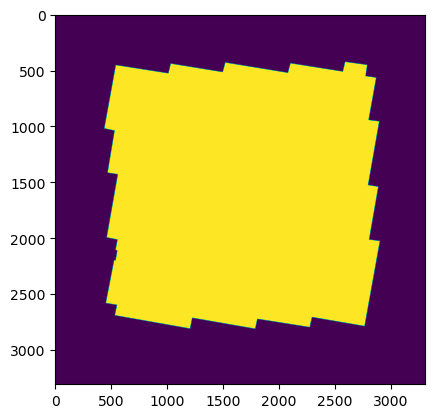

In [76]:
from matplotlib import pyplot as plt
plt.imshow(mask)

In [77]:
mask.reshape(1, *mask.shape).shape

(1, 3307, 3307)

In [78]:
fits.writeto(PATH_DATA+'s2cosmos_main_mask.fits', data=mask.reshape(1, *mask.shape).astype(int), header=img_hdr, overwrite=True)